Importing

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import string
import emoji
import nltk

nltk.download('stopwords') # download stopwords
nltk.download('wordnet') #download wordnet

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.corpus import stopwords # import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

#classifier
from xgboost import XGBClassifier

#setting up stop_words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mdgoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mdgoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#reading information from dataset 1
df = pd.read_excel("C:/Main/Mihir/Sem 5/IE406/Project/archive/LabeledText.xlsx")
df = df.drop(['File Name'], axis=1)
df.head(3)

#reading information from dataset 2
# def labelIt(num):
#     if(num==0):return "Negative"
#     elif(num==2):return "Neutral"
#     elif(num==4):return "Positive"

# DATASET_ENCODING = "ISO-8859-1"
# DATASET_COLUMNS = ["LABEL", "ids", "date", "flag", "user", "Caption"]
# df = pd.read_csv("C:/Main/Mihir/Sem 5/IE406/Project/archive/training.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
# df = df.drop(columns=['ids','date','flag','user'])
# df.LABEL = df.LABEL.apply(lambda num : labelIt(num))
# df.head(3)

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive


In [3]:
#checking out the size and labels of the dataset
print('size of the dataset:', len(df))
print('different labels:', df['LABEL'].nunique())

size of the dataset: 4869
different labels: 3


Preprocessing

In [4]:
#usnig lemmatizer in order to reduce dimension (eg. (run, running, ran) -> run)
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)

#removing all the stopwords which does not have sentiment meaning (eg. and, a, the, etc.)
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

#removing all numerics
def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

#converting all the text to lower case
def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

#removing all the punctuations
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace(";","")
    text = re.sub('\\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

#removing all the urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#removing all the small sentences
def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.Caption.iloc[i].split()) < 3:
            df.Caption.iloc[i] = np.nan

#removing negation (eg. not done --> not_done)
def handle_negations(text):
    negation_words = ['not', 'no', 'never', 'none', 'nobody', 'nowhere', 'nothing', 'neither']
    words = text.split()
    modified_words = []
    is_negation = False
    for word in words:
        if word in negation_words:
            is_negation = True
        elif is_negation:
            modified_words.append('not_' + word)
            is_negation = False
        else:
            modified_words.append(word)
    processed_text = ' '.join(modified_words)
    return processed_text
            
#normalizing the text
def normalize_text(df):
    df.Caption=df.Caption.apply(lambda text : lower_case(text))
    df.Caption=df.Caption.apply(lambda text : remove_stop_words(text))
    df.Caption=df.Caption.apply(lambda text : remove_numbers(text))
    df.Caption=df.Caption.apply(lambda text : remove_punctuations(text))
    df.Caption=df.Caption.apply(lambda text : remove_urls(text))
    df.Caption=df.Caption.apply(lambda text : lemmatization(text))
    df.Caption=df.Caption.apply(lambda text : handle_negations(text))
    return df

#removing all the small sentences
def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= remove_numbers(sentence)
    sentence= remove_punctuations(sentence)
    sentence= remove_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence


In [5]:
#normalizing our df
df = normalize_text(df)

In [6]:
#labelling our df i.e. giving numerics to our non-numeric label
le = LabelEncoder()
df['LABEL'] = le.fit_transform(df['LABEL'])

In [7]:
#Split data
X = df.Caption
y = df.LABEL
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)

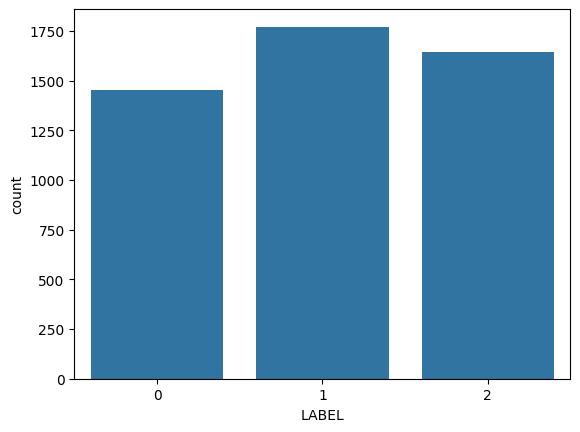

In [8]:
#See the distribution
sns.countplot(x='LABEL', data=df);

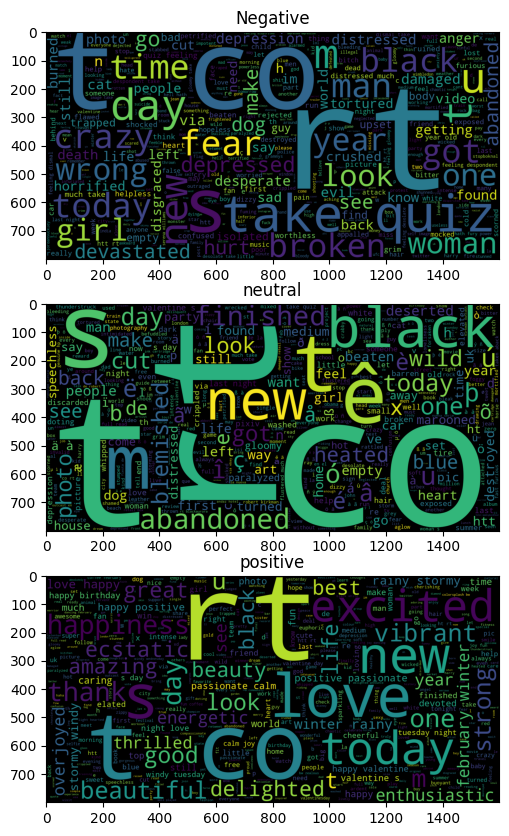

In [9]:
#separating data by their labels
df_negative = df.groupby('LABEL')['Caption'].get_group(0)
df_neutral = df.groupby('LABEL')['Caption'].get_group(1)
df_positive = df.groupby('LABEL')['Caption'].get_group(2)

#making wordclouds
wc0 = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df_negative))
wc1 = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df_neutral))
wc2 = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df_positive))

#vizualize wordclouds
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(wc0)
plt.title('Negative')
plt.subplot(3, 1, 2)
plt.imshow(wc1)
plt.title('neutral')
plt.subplot(3, 1, 3)
plt.imshow(wc2)
plt.title('positive')
plt.show()

In [10]:
def custom_tokenizer(text):
    tokens = []
    words = text.split()

    for word in words:
        emojis = [c for c in word if c in emoji.EMOJI_DATA]
        if emojis:
            tokens.extend(emojis)
        else:
            tokens.append(word)

    return tokens

#building the vectoriser
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
#use the below vectoriser if the data contains emojis
#vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000,tokenizer=custom_tokenizer)
#train the vectoriser
vectoriser.fit(X_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [11]:
#Vectorise data
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

Training and Testing

In [12]:
#Testing with Random Forest Classifier
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)
y_pred2 = RFmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("accuracy:", accuracy)

accuracy: 0.6776180698151951


In [13]:
#Testing with XGBoost
XGmodel = XGBClassifier()
XGmodel.fit(X_train, y_train)
y_pred3 = XGmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred3)
print("accuracy:", accuracy)

accuracy: 0.6827515400410678


In [14]:
#Testing with SVM
SVM = SVC(kernel = 'linear', random_state = 0)
SVM.fit(X_train, y_train)
y_pred4 = SVM.predict(X_test)
accuracy = accuracy_score(y_test, y_pred4)
print("accuracy:", accuracy)

accuracy: 0.6971252566735113


In [15]:
#Tesing with Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred5 = LRmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred5)
print("accuracy:", accuracy)

accuracy: 0.6960985626283368


In [16]:
#Testing with Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,y_train)
y_pred6 = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred6)
print("accuracy:", accuracy)

accuracy: 0.6529774127310062
